#  **01: ETL - DEEPTWEET**
### José Eduardo Viveros Escamilla | A01710605

Importacion de librerias necesarias 

In [37]:
import pandas as pd
import numpy as np
import re
import string
import emoji
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pickle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Carga y estructura del Dataset 
Leer correctamente el dataset Sentiment140, explorar su estructura básica y quedarnos solo con las columnas necesarias para el análisis de tendencias.

In [32]:
# Cargar el dataset
df = pd.read_csv(
    r'C:\Users\josed\Documents\IA\BENJI\sentiment140\training.1600000.processed.noemoticon.csv',
    encoding='latin-1',
    header=None
)
# Asignar nombres a las columnas (según estructura del Sentiment140)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Verificar estructura
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Eliminamos columnas inecesarias, nos quedamos con **target** que es el que nos indica basicamente el sentimiendo del tweet, la **fecha** con la que podria hacer el **analisis de tendencias** y el mismo **texto** del tweet

In [34]:
df = df[['target', 'date', 'text']]
df.head(5)

,target,date,text
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


* En el contexto del data set solo tenemos dos variables que nos hablan acerca de como es percibido el tweet, al ser un un data set de Kaggle ya viene estandarizado para poder trabajar con el y con una feature muy especifica como lo puede ser esa



In [35]:
print("Valores únicos en 'target':", df['target'].unique())
print("Tamaño total del dataset:", len(df))
df['target'].value_counts()


Valores únicos en 'target': [0 4]
Tamaño total del dataset: 1600000


target
0    800000
4    800000
Name: count, dtype: int64

A si mismo normalizamos los datos a 0 y 1

In [36]:
df['target'] = df['target'].replace({4: 1})

### Analisis exploratorio de datos 

Solo graficamos la cantidad de tweets que tenemos que son 50/50 postivos y negativos

C:\Users\josed\AppData\Local\Temp\ipykernel_19968\436160857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette=['#FF6B6B', '#51CF66'])


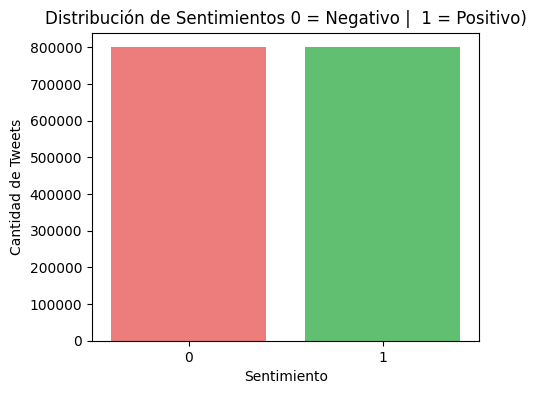

target
0    50.0
1    50.0
Name: proportion, dtype: float64


In [41]:
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df, palette=['#FF6B6B', '#51CF66'])
plt.title('Distribución de Sentimientos 0 = Negativo |  1 = Positivo)')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Tweets')
plt.show()

print(df['target'].value_counts(normalize=True)*100)

>Para ver como es que los tweets negavatvios y positivos se pueden ver imprimimos unos ejemplos randoms

In [46]:
print("Ejemplos de tweet NEGATIVOs :(\n", 
      "1", df[df['target']==0]['text'].iloc[34],
      "\n 2", df[df['target']==0]['text'].iloc[54],
      "\n 3", df[df['target']==0]['text'].iloc[67])

print("\nEjemplo de tweet POSITIVO :D\n", 
      "1",df[df['target']==1]['text'].iloc[78],
      "\n 2", df[df['target']==0]['text'].iloc[32],
      "\n 3", df[df['target']==0]['text'].iloc[88])

Ejemplos de tweet NEGATIVOs :(
 1 @HumpNinja I cry my asian eyes to sleep at night  
 2 I need a hug  
 3 Mo jobs, no money.  how in the hell is min wage here 4 f'n clams an hour?

Ejemplo de tweet POSITIVO :D
 1 had a good tech meeting at clubZone - dinner was sushi  
 2 thought sleeping in was an option tomorrow but realizing that it now is not. evaluations in the morning and work in the afternoon!  
 3 why is it always the fat ones?! 


Ahora nos pasamos a graficar el tamaño de los tweetes, esto atraves de nuestra feature **text** y ver como se comporta nuestar distribucion

Text(0.5, 1.0, 'Distribución de la longitud de los tweets por sentimiento')

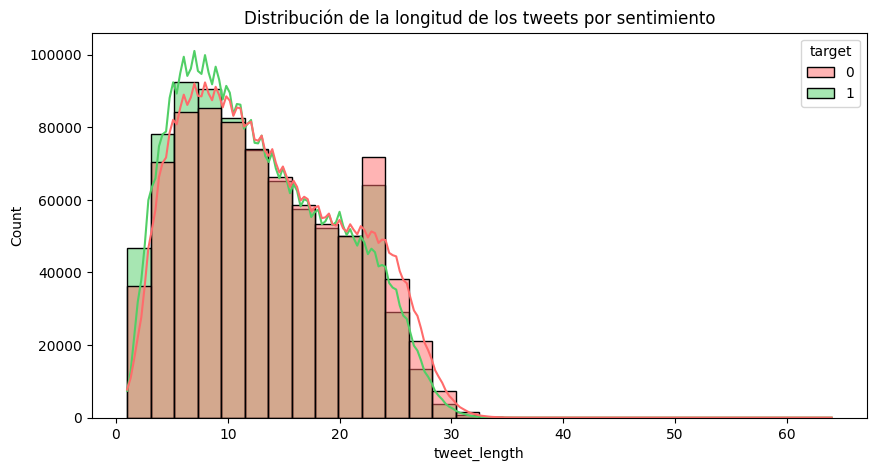

In [48]:
df['tweet_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='tweet_length', hue='target', bins=30, kde=True, palette=['#FF6B6B', '#51CF66'])
plt.title('Distribución de la longitud de los tweets por sentimiento')

Viendo el resultado nos podemos dar cuenta que en si la mayoria delos tweets tiene en su mayoria entre 5 a 20 palabras, tanto negatviso como postivos, nos podemos dar cuenta en las lineas rojas y verdes qson muy similares pues la longitud de los tweets es muy similar 
* Esto significa que la longitud del tweet no predice el sentimiento de este

Con esto podemos visalizar las palabras mas utlizadas en ambos tipos de tweets, ya que ahi mismo es donde deberia que haber la doferencia entre los tweets si no es en la longitud deberia que ser en el contenido, asi que nos podemos dar una idea de esa forma

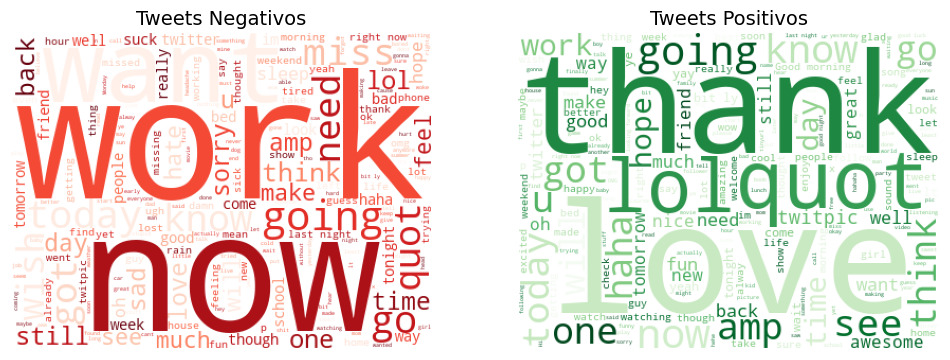

In [50]:
neg_text = " ".join(df[df['target']==0]['text'])
pos_text = " ".join(df[df['target']==1]['text'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300, background_color='white', colormap='Reds').generate(neg_text))
plt.title('Tweets Negativos', fontsize=14)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color='white', colormap='Greens').generate(pos_text))
plt.title('Tweets Positivos', fontsize=14)
plt.axis('off')

plt.show()
